# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import cv2
import tensorflow as tf
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import AdamW, Adam
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.applications import MobileNet
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import time
from keras.callbacks import Callback
from concurrent.futures import ProcessPoolExecutor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.__version__

'2.13.0'

In [5]:
!nvidia-smi

Tue Dec 12 11:19:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Resizing the images to (224, 224) as required by MobileNet

## Images aren't resized

(224, 224, 3)


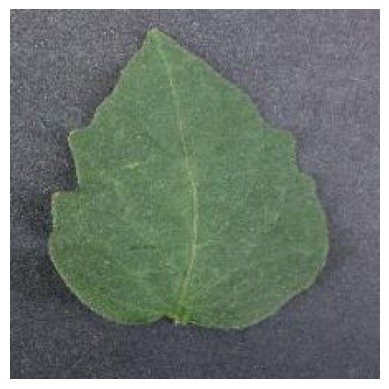

In [3]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/mobnet/mobilenet/Dataset-binary-tomato/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___gh_hl_leaf_259.1.jpg'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

## Resizing the images

In [ ]:
np_dir = '/kaggle/input/plant-disease-classifcation/Plant-Disease-v1/Dataset'

target_size = (224, 224)

print(os.listdir(inp_dir))

for folder in os.listdir(inp_dir):


  folder_path = os.path.join(inp_dir, folder)
  if os.path.isdir(folder_path):

    print(f'Processing images in the folder: {folder}')
    for filename in os.listdir(folder_path):

      if filename.endswith(('.jpg', '.jpeg', '.png')):



        #load the img
        img_path = os.path.join(folder_path, filename)
        img = mpimg.imread(img_path)

        #resizing
        resized_img = cv2.resize(img, target_size)

        #overwriting the input images with the resized images
        mpimg.imsave(img_path, resized_img)


print('Done with Resizing')

## Checking whether or not the image have been resized

(224, 224, 3)


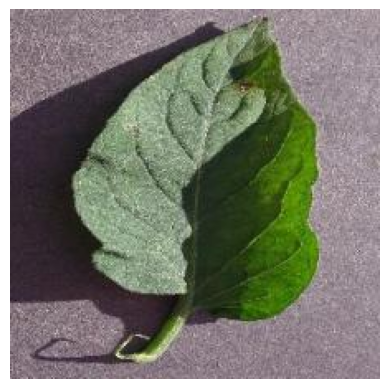

In [4]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/mobnet/mobilenet/Dataset-binary-tomato/Tomato___unhealthy/002213fb-b620-4593-b9ac-6a6cc119b100___com.g_tgs_fl_8360.jpg'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

# Converting the images to array and normalizing the

In [5]:
def convert_img_to_array(image_dir):
  try:
    img = cv2.imread(image_dir)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])

  except Exception as e:
    print(f'Error: {e}')
    return None

# Reading the images and converting them into an array

In [13]:
def process_directory(args):
    directory, temp = args
    images = []
    labels = []
    for files in os.listdir(directory):
        img_path = os.path.join(directory, files)
        images.append(convert_img_to_array(img_path))
        labels.append(binary_labels[temp])
    return images, labels

# Parallel Processing the image_list and label_list

In [14]:
dir = '/kaggle/input/mobnet/mobilenet/Dataset-binary-tomato'
all_labels = os.listdir(dir)
binary_labels = list(range(2))

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor() as executor:
    args_list = [(os.path.join(dir, directory), temp) for temp, directory in enumerate(all_labels[:2])]
    results = list(executor.map(process_directory, args_list))

# Unpack the results
image_list, label_list = zip(*results)
image_list = [item for sublist in image_list for item in sublist]
label_list = [item for sublist in label_list for item in sublist]

# Reading the images one by one and converting them into an array

In [6]:
#dir = '/content/drive/MyDrive/Plant-Disease-v1/Dataset'
dir = '/kaggle/input/mobnet/mobilenet/Dataset-binary-tomato'
image_list, label_list = [], []
#all_labels = os.listdir('/content/drive/MyDrive/Plant-Disease-v1/Dataset')
all_labels = os.listdir('/kaggle/input/mobnet/mobilenet/Dataset-binary-tomato')
binary_labels = [0, 1]
#temp = -1

# binary_labels = list(range(38))

#Reading and Converting the image into to numpy array
for temp, directory in enumerate(all_labels[:2]):
    plant_img_list = os.listdir(f'{dir}/{directory}')
    for files in plant_img_list:
        img_path = f'{dir}/{directory}/{files}'
        image_list.append(convert_img_to_array(img_path))
        label_list.append(binary_labels[temp])
#Since the datasize of PlantVillage is >50,000 images, the process is divided and processed in two batches
#as the cpu was unable to process this in a single go
'''

#Processing the first 19 directories
for temp, directory in enumerate(all_labels[:19]):
    plant_img_list = os.listdir(f'{dir}/{directory}')
    for files in plant_img_list:
        img_path = f'{dir}/{directory}/{files}'
        image_list.append(convert_img_to_array(img_path))
        label_list.append(binary_labels[temp])

#Use the code below if you have high performing CPUs
for directory in all_labels:
  plant_img_list = os.listdir(f'{dir}/{directory}')
  temp += 1
  for files in plant_img_list:
    img_path = f'{dir}/{directory}/{files}'
    image_list.append(convert_img_to_array(img_path))
    label_list.append(binary_labels[temp])
    '''

"\n\n#Processing the first 19 directories\nfor temp, directory in enumerate(all_labels[:19]):\n    plant_img_list = os.listdir(f'{dir}/{directory}')\n    for files in plant_img_list:\n        img_path = f'{dir}/{directory}/{files}'\n        image_list.append(convert_img_to_array(img_path))\n        label_list.append(binary_labels[temp])\n\n#Use the code below if you have high performing CPUs\nfor directory in all_labels:\n  plant_img_list = os.listdir(f'{dir}/{directory}')\n  temp += 1\n  for files in plant_img_list:\n    img_path = f'{dir}/{directory}/{files}'\n    image_list.append(convert_img_to_array(img_path))\n    label_list.append(binary_labels[temp])\n    "

In [12]:
print(all_labels[1])
print(image_list[0].shape)

Tomato___unhealthy
(224, 224, 3)


In [ ]:
'''
#Processing the next 19 directories
for temp, directory in enumerate(all_labels[19:]):
    plant_img_list = os.listdir(f'{dir}/{directory}')
    for files in plant_img_list:
        img_path = f'{dir}/{directory}/{files}'
        image_list.append(convert_img_to_array(img_path))
        label

Checking the frequecny of images in each class

In [13]:
labels_count = pd.DataFrame(label_list).value_counts()
labels_count

1    11211
0     1591
Name: count, dtype: int64

# Splitting the data into train test split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2, random_state = 67)

# Normalizing the data

In [15]:
x_train = np.array(x_train, dtype = np.float16) / 255.0
x_test = np.array(x_test, dtype = np.float16) / 255.0
x_train = x_train.reshape(-1, 224, 224, 3)
x_test = x_test.reshape(-1, 224, 224, 3)

In [24]:
print(x_test.shape)

(2561, 224, 224, 3)


In [20]:
print(len(y_train))

10241


# One Hot Encoding

In [21]:
# y_train = y_train.reshape((8192, 4))
y_train = to_categorical(y_train)
# y_train = to_categorical(y_train)
# y_test = y_test.reshape((8192, 4))
y_test = to_categorical(y_test)
# y_train = y_train
# y_test = y_test

In [22]:
print(y_train.shape)

(10241, 2)


In [23]:
print(y_test.shape)

(2561, 2)


# Creating the model

In [25]:
IMAGE_SIZE = [224, 224]
mobilenet = MobileNet(input_shape = IMAGE_SIZE + [3], weights = '/kaggle/input/mobnet/mobilenet/weights/mobilenet_1_0_192_tf_no_top.h5', include_top=False)

In [26]:
for layer in mobilenet.layers:
    layer.trainable = False

In [28]:
x = GlobalAveragePooling2D()(mobilenet.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

# Compiling the model

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Splitting the training set into train and validation set

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=67)
# x_train = np.array(x_train).reshape(-1, 224, 224, 3)
# y_train = np.array(y_train)

In [31]:
print(x_train.shape)

(10241, 224, 224, 3)


In [33]:
print(y_train)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Training the Model

In [35]:
epochs = 50
batch_size = 64
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))
end_time = time.time()
total_time = end_time - start_time
print('Training time is: ', total_time)
model.save('/kaggle/working/models/plant_disease_model_mobilemet.h5')

Epoch 1/50
128/128 [==============================] - 25s 123ms/step - loss: 0.3040 - accuracy: 0.8833 - val_loss: 0.2253 - val_accuracy: 0.9102
Epoch 2/50
128/128 [==============================] - 11s 88ms/step - loss: 0.1846 - accuracy: 0.9246 - val_loss: 0.1532 - val_accuracy: 0.9390
Epoch 3/50
128/128 [==============================] - 11s 88ms/step - loss: 0.1331 - accuracy: 0.9534 - val_loss: 0.1170 - val_accuracy: 0.9639
Epoch 4/50
128/128 [==============================] - 11s 88ms/step - loss: 0.1055 - accuracy: 0.9663 - val_loss: 0.0968 - val_accuracy: 0.9712
Epoch 5/50
128/128 [==============================] - 11s 89ms/step - loss: 0.0882 - accuracy: 0.9744 - val_loss: 0.0827 - val_accuracy: 0.9766
Epoch 6/50
128/128 [==============================] - 11s 89ms/step - loss: 0.0759 - accuracy: 0.9783 - val_loss: 0.0724 - val_accuracy: 0.9815
Epoch 7/50
128/128 [==============================] - 11s 89ms/step - loss: 0.0670 - accuracy: 0.9819 - val_loss: 0.0649 - val_accuracy

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plots for Loss and Accuracy

## Training loss and accuracy

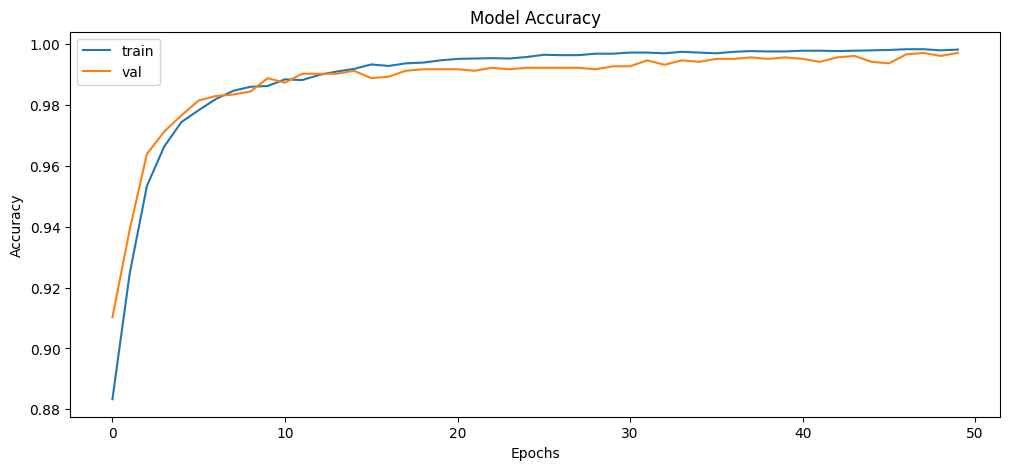

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

In [37]:
scores = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {scores[1] * 100}')
scores

81/81 [==============================] - 3s 37ms/step - loss: 0.0164 - accuracy: 0.9965
Test Accuracy: 99.64857697486877


[0.016424590721726418, 0.9964857697486877]

In [38]:
y_pred = model.predict(x_test)

81/81 [==============================] - 3s 36ms/step


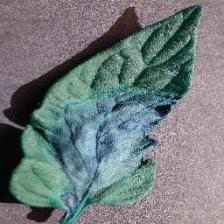

In [39]:
img = array_to_img(x_test[11])
img

In [40]:
print('original label: ', all_labels[np.argmax(y_test[11])])
print('predicted label: ', all_labels[np.argmax(y_test[11])])
print(y_pred[2])
print((y_test).shape)

original label:  Tomato___unhealthy
predicted label:  Tomato___unhealthy
[0.00775547 0.99224454]
(2561, 2)


In [41]:
for i in range(0, len(y_test)):
    print(all_labels[np.argmax(y_test[i])], ' - ', all_labels[np.argmax(y_pred[i])])

Tomato___healthy  -  Tomato___healthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___healthy  -  Tomato___healthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___healthy  -  Tomato___healthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___healthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato___unhealthy  -  Tomato___unhealthy
Tomato